# Juliaで線型方程式の解の精度保証付き数値計算

$A\in \mathbb{K}^{n\times n}$ を $n$ 次行列、$b\in\mathbb{K}^n$ を $n$ 次元ベクトルとする。ただし $\mathbb{K}=\mathbb{C}$ or $\mathbb{R}$ とする。このとき、線型方程式

$$
Ax=b
$$

の解 $\tilde{x}\in\mathbb{K}$ の精度保証付き数値計算法を紹介する。
行列 $A$ が正則（$\det(A)\neq 0$）ならば、逆行列 $A^{-1}$ が存在し、線型方程式は厳密解がただ一つ存在する。したがって、精度保証付き数値計算で必要なことは、

- 行列 $A$ が正則である
- 厳密解 $\tilde{x}$ の存在する範囲を計算する（誤差評価）

の2つ。

**注意**　数値計算で利用する数値の精度を多数桁に拡張すれば、より高精度な精度保証付き数値計算が可能になるが、今回は倍精度浮動小数点数（Float64）のみを使った精度保証付き数値計算を紹介する。多倍長数値を使った区間演算等は別の機会に。


## 区間ガウスの消去法

区間ガウスの消去法（IG）はいわゆるガウスの消去法を全て区間演算に置き換えた方法であり、"理論上は"解の厳密な包含が得られることになる。しかし、区間ガウスの消去法は、係数行列 $A$ の
次数 $n$ がある程度以上の大きくなると、解の誤差半径が爆発的に大きくなってしまい、適用不可能になるという致命的な欠点がある。これは区間演算による区間幅の増大が原因で、丸め誤差の過大評価によって計算結果が物凄く粗い評価となってしまう。例えば、`IntervalArithmetic.jl`は、区間ガウスの消去法に基づいて線型方程式の求解ができる。

In [2]:
using IntervalArithmetic, BenchmarkTools
A = [2 2 3; -2 5 1; 5 6 9];
b = A*[2,2,1];　 # Exact solution: (2,2,1)^T

A = map(interval, A);
b = map(interval, b);
# b = SVector{3,Interval}(b);
# A = SMatrix{3,3}(A);
# typeof(b)
# b = SVector{3}(b);
# A = SMatrix{3,3}(A);
# x = A\b
x = A\b
maximum(radius.(x[:]))

3.26405569239796e-14

解の包含の区間幅は約 $10^{-14}$ と十分小さな区間になっていると思われるが、行列のサイズ $n$ が大きくなるにつれて、区間幅が増大し、この方法は破綻する。

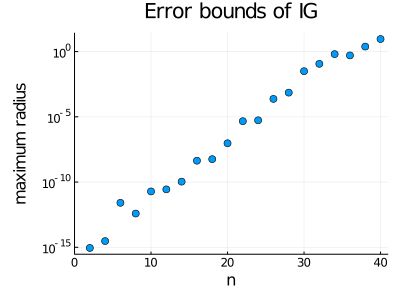

In [3]:
using Plots
index = 2:2:40;
max_rad = zeros(size(index));
i = 1;
for n ∈ index
    A = randn(n,n);
    b = A*ones(n);

    A = map(interval, A)
    b = map(interval, b)

#     A = SMatrix{n,n}(A);
#     b = SVector{n}(b);
    
    x = A\b
    max_rad[i] = maximum(radius.(x[:]));
    i += 1;
end
plot(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,41),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(400,300),          #プロットのサイズ
    label = "without pre-conditioned",#凡例のラベル
    legend = false,                   #凡例は今回は消す
)

ちなみに区間ガウスの消去法（IG）の名誉挽回のために、もしも $R\approx A^{-1}$ なる前処理行列を方程式の右から区間行列積でかけた方程式

$$
    RAx = Rb
$$

にIGを行うと、上のような区間幅の増大は起こらない（文献1参照）。しかし、IGの計算コストに加えて、$R$ を計算するコストが必要で計算時間がかかる。

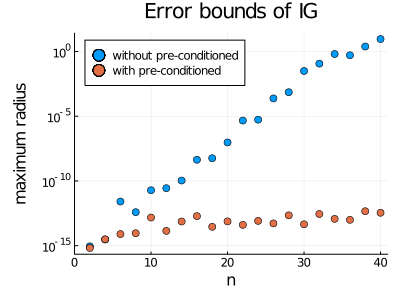

In [4]:
function int_Gauss(A, b)
    R = map(interval,inv(A));
    A = R*map(interval, A)
    b = R*map(interval, b)
    return A\b
end

i = 1;
for n ∈ index
    A = randn(n,n);
    b = A*ones(n);

    x = int_Gauss(A,b)
    
    max_rad[i] = maximum(radius.(x[:]));
    global i += 1;
end
plot!(index, max_rad, yscale=:log10,
    xlabel       ="n",                #X軸のラベル
    ylabel       ="maximum radius",   #Y軸のラベル
    xlims        =(0,41),             #X軸の範囲
    title="Error bounds of IG",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(400,300),          #プロットのサイズ
    label = "with pre-conditioned",   #凡例のラベル
    legend = :topleft,                #凡例
)

In [7]:
n =1000;
A = randn(n,n);
b = A*ones(n);
@time x = int_Gauss(A,b);
maximum(radius.(x))

 74.323475 seconds (30 allocations: 69.215 MiB, 0.74% gc time)


8.9117047075149e-11

## BLAS/LAPACKを使う高速精度保証付き数値計算法

行列 $A$ が密行列の場合の精度保証方法を紹介する。この方法の特長は行列計算単位で[区間演算を実行](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html)することができる。つまり BLAS や LAPACK などの高速で信頼性の高い数値計算ライブラリを利用することができる。そして、区間ガウスの消去法とは違って、次数 $n$ が数千以上のような比較的大規模な行列も計算が成功する。

In [5]:
using LinearAlgebra
n = 5000;
A = randn(n,n);
b = A*ones(n);
@time x = A\b; # Lapack
# x[1:3]
# setprecision(BigFloat,128)
# A = map(BigFloat,A);
# b = A*map(BigFloat,ones(n));
# @time x_dd = A\b; # Native

  1.038859 seconds (2.12 M allocations: 294.001 MiB, 3.02% gc time)


### ノルム評価

次の定理を使用する。

**定理 1**　行列 $A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^{n}$ に対して、線型方程式 $Ax=b$ の近似解を $\bar{x}$ とする。いま行列 $R\in\mathbb{R}^{n\times n}\approx A^{-1}$が、

$$
\|I-RA\|<1
$$

をみたすとき、

$$
\left\|A^{-1}b-\bar{x}\right\|\le\frac{\|R(b-A \bar{x})\|}{1-\|I-R A\|}
$$

が成り立つ。ただし、$I$ は $n$ 次単位行列とする。


**証明**
$$
\|A^{-1}b - \bar{x}\|=\|(I-(I-RA))^{-1}R(b-A\bar{x})\|\le \frac{\|R(b-A\bar{x})\|}{1-\|I-RA\|}.
$$

ここで、最後の不等式は $\|T\|<1$ となる行列 $T$ に対して、$\|(I-T)^{-1}\|\le 1/(1-\|T\|)$ となる事実（ノイマン級数の上からの評価、$T:=I-RA$）を使っている。<div style="text-align: right;">$\Box$</div>

この定理の十分条件は次の命題から行列 $A$ の正則性を保証している。

**命題**　$\rho(I-RA)\le \|I-RA\|<1$ とする。このとき行列 $R$ と $A$ は正則となる。

**証明** もしも正則でないとすると、$0\neq x\in\mathrm{Ker}(A)$ に対して、$(I-RA)x=x$ となる。すなわち行列 $I-RA$ は少なくとも一つ固有値 $1$ を持つ。しかしこれは $\rho(I-RA)<1$ に矛盾する。<div style="text-align: right;">$\Box$</div>

In [6]:
include("int_num_linalg.jl"); # mm_ufpを使用する
using LinearAlgebra, IntervalArithmetic

# bug fix for inf-norm of Interval vectors: 区間の大小比較でバグりinf-normが計算できない問題があるための一時的な解決方法
function LinearAlgebra.generic_normInf(x)
    (v, s) = iterate(x)::Tuple
    maxabs = norm(v)
    while true
        y = iterate(x, s)
        y === nothing && break
        (v, s) = y
        vnorm = norm(v)
        maxabs = ifelse(isnan(maxabs), maxabs, max(maxabs, vnorm))
    end
    return float(maxabs)
end

function verifylss_naive(A,b)
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    #########
    C_mid, C_rad = mm_ufp(R,A);
    C = C_mid .± C_rad;
    α = opnorm(Matrix{Float64}(I, n, n)-C,Inf)# Interval arithmetic
    #########
    if α < 1
        x̄ = map(Interval,x̄);
        r = A*x̄ - b; # Interval arithmetic
        err = norm(R*r,Inf)/(1-α); # Interval arithmetic
#         err = maximum(abs.(R*r))/(1-α); # Interval arithmetic
    else
        println("Oh my way, verification is failed...")
        err = nan;
    end
    return x = x̄ .± err.hi
end

verifylss_naive (generic function with 1 method)

In [7]:
n = 1000;
A = randn(n,n);
b = A*ones(n);
# @time x̄ = A\b;
@time x = verifylss_naive(A,b);
maximum(radius.(x))

  3.354985 seconds (6.59 M allocations: 411.867 MiB, 7.90% gc time)


1.2799517001838012e-10

#### 丸めの向きを変更しない精度保証方法

これをもう少し速くしたい。丸めの向きを変更しない次のような評価式を使う。

連立一次方程 $Ax=b$, $A\in\mathbb{F}^{n\times n}$, $b\in\mathbb{F}^{n}$ において、$R\approx A^{-1}$ として、上の定理における $\|I-RA\|_{\infty}$ の上からの評価は最近点丸めのみを用いて、次のように計算できる。

$$
    a_1:=\mathrm{muls}(|A|),\quad a_2:=\mathrm{muld}(|R|, a_1),
$$

$$
    \alpha_1:=\mathrm{muls}(\mathrm{fl}(I-RA)),\quad \alpha_2:=\mathrm{succ}(\mathrm{fl}((n\mathbf{u})\cdot a_2)),\quad \alpha_3:=\mathrm{fl}(n\,\mathbf{S}_{\min}\cdot e_{n}).
$$

ただし、$\mathbf{u}:=2^{-53}$, $\mathbf{S}_{\min}:=2^{-1074}$, $\mathbf{F}_{\min}:=2^{-1022}$, $e_n:=(1,1,\dots,1)\in\mathbb{F}^n$。そして $r\in\mathbb{F}$ に対して、$\mathrm{succ}(r):=\min\{f\in \mathbb{F}:r<f\}$, $\mathrm{ufp}(r):=2^{\lfloor\log_2|r|\rfloor}$として

$$
\operatorname{muls}(A):=\operatorname{succ}(\mathrm{fl}(|A| e_n+(n-1) \mathbf{u} \cdot \operatorname{ufp}(|A| e_n)))\ (\geq|A| e_n)
$$

$$
\operatorname{muld}(A, x):=\operatorname{succ}(\mathrm{fl}(|A x|+(n+2) \mathbf{u} \cdot \operatorname{ufp}(|A \| x|)+\mathbf{F}_{\min} \cdot e))\ (\geq|A x|).
$$

このとき、$\max(\alpha_1)<1$ であれば、

$$
\|I-RA\|_{\infty}\le \left\|\mathrm{fl}\left(\operatorname{succ}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)+3 \mathbf{u} \cdot \operatorname{ufp}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)\right)\right\|_{\infty}=:\alpha
$$

と評価できる。さらに、$\|R(A\bar{x}-b)\|_{\infty}$の上からの評価は次のように得られる。$r:=A\bar{x}-b$として、

$$
r_{\mathrm{mid}}=\mathrm{fl}(r),\quad 
r_{\mathrm{rad}}=\mathrm{fl}((n+3) \mathbf{u} \cdot \operatorname{ufp}(|A \| \bar{x}|+|b|)+\mathbf{F}_{\min} \cdot e_n)
$$

で残差 $r$ の包含が $\mathbf{r}:=\langle r_{\mathrm{mid}}, r_{\mathrm{rad}}\rangle$と得られ、

$$
    |Rr|\le (|Rr_{\mathrm{mid}}| + |R|r_{\mathrm{rad}})
$$

より、

$$
    b_1:=\operatorname{muld}(R, r_{\mathrm{mid}}),\quad b_{2}:=\operatorname{muld}(|R|, r_{\mathrm{rad}})
$$

最終的に、

$$
    \|R(A\bar{x}-b)\|_{\infty}\le \max(\mathrm{succ}(b_1+b_2)).
$$

In [8]:
using IntervalArithmetic
function muls(A)
    u = 2.0^(-53);
    n = size(A,2);
    e = ones(n);
    return succ.(abs.(A)*e+(n-1)*u*ufp.(abs.(A)*e))
end

function muld(A,x)
    u = 2.0^(-53);
    Fmin = 2.0^(-1022);
    n = size(A,2);
    e = ones(n);
    return succ.(abs.(A*x) + (n+2)*u*ufp.(abs.(A)*abs.(x)) + Fmin*e)
end

function verifylss(A,b)
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    ######### upper bound of ||I-RA||
    u = 2.0^(-53);
    Smin = 2.0^(-1074);
    Fmin = 2.0^(-1022);
    e = ones(n);
    a₁ = muls(abs.(A));
    a₂ = muld(abs.(R), a₁);
    α₁ = muls(I-R*A);
    α₂ = succ.(n*u*a₂);
    α₃ = n*Fmin*e;
    if maximum(α₁) < 1
        α = norm(succ.(α₁ + α₂ + α₃ + u*e) + 3*u*ufp.(α₁ + α₂ + α₃ + u*e),Inf);
    else
        println("α₁ is less than 1")
        err = nan;
    end
    if α < 1
        ######### upper bound of ||Ax̄-b||
        rmid = A*x̄ - b;
        rrad = (n+3)*u*ufp.(abs.(A)*abs.(x̄) + abs.(b)) + Fmin*e;
        b₁ = muld(R,rmid);
        b₂ = muld(abs.(R),rrad);
        r_inf_norm = maximum(succ.(b₁ + b₂));
        #########
        err = r_inf_norm/(1-map(Interval,α));
    else
        println("Oh my way, verification is failed...")
        err = nan;
    end
    return x = x̄ .± err.hi
end

verifylss (generic function with 1 method)

In [9]:
# n = 1000;
# A = randn(n,n);
# b = A*ones(n);
@time x̄ = A\b;
@time x₁ = verifylss_naive(A,b);
@show maximum(radius.(x₁));
@time x₂ = verifylss(A,b);
@show maximum(radius.(x₂));

  0.005713 seconds (4 allocations: 7.645 MiB)
  1.080704 seconds (42 allocations: 108.622 MiB, 1.09% gc time)
maximum(radius.(x₁)) = 1.2799517001838012e-10
  0.956949 seconds (2.22 M allocations: 223.173 MiB, 4.26% gc time)
maximum(radius.(x₂)) = 5.463306695929759e-9


計算時間は早くなった。しかし、誤差評価が約100倍大きくなるため、少し悔しい。


### 成分毎評価

**定理 2（山本の定理）** $A$, $R\in\mathbb{R}^{n\times n}$, $b$, $\bar{x}\in\mathbb{R}^n$, $G:=I-RA$ とする。このとき、$\|G\|_{\infty}<1$ ならば、行列 $A$ は正則であり、次の評価が成り立つ。

$$
|A^{-1}b-\bar{x}|\le |R(b-A\bar{x})| + \frac{\|R(b-A\bar{x})\|_{\infty}}{1-\|G\|_{\infty}}|G|e_n,
$$

ここで、$e_n = (1,1,\dots,1)\in\mathbb{R}^n$で、行列・ベクトルの絶対値は成分毎に絶対値を取るものとし、不等式は成分毎に不等式が成立しているものとする。

**証明** $A^{-1}=(RA)^{-1}R$ ($R$ は正則行列)であり、$\|G\|_{\infty}<1$ より、

$$
(RA)^{-1}=(I-G)^{-1} = I + G + G^2 + \dots = I + G(I-G)^{-1}
$$

となる。任意の $v\in\mathbb{R}^n$ に対して、$|v|\le\|v\|_{\infty} e_n$ であることに注意すると、

\begin{align}
|A^{-1}b-\bar{x}| &= |(RA)^{-1}R(b-A\bar{x})|\\
&= |(I+G(I-G)^{-1})R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+|G||(I-G)^{-1}R(b-A\bar{x})|\\
&\le |R(b-A\bar{x})|+\|(I-G)^{-1}\|_{\infty}\|R(b-A\bar{x})\|_{\infty}|G|e_n
\end{align}

となり、$\|(I-G)^{-1}\|_{\infty}\le 1/(1-\|G\|_{\infty})$ を用いると上記の評価式を得る。
<div style="text-align: right;">$\Box$</div>

In [10]:
function verifylss_yamamoto(A,b) # verify the solution element-wisely
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    #########
    C_mid, C_rad = mm_ufp(R,A);
    C = C_mid .± C_rad;
    G = Matrix{Float64}(I, n, n) - C;
    α = opnorm(G,Inf)# Interval arithmetic
    #########
    if α < 1
        x̄ = map(Interval,x̄);
        r = A*x̄ - b; # Interval arithmetic
        Rr = R*r;
        err = abs.(Rr) + supremum(norm(Rr,Inf))/(1-α)*(abs.(G)*ones(n)); # Interval arithmetic
    else
        println("Oh my way, verification is failed...")
        err = nan;
    end
    return x = x̄ .± supremum.(err)
end

verifylss_yamamoto (generic function with 1 method)

In [11]:
using Statistics
@time x₁ = verifylss_naive(A,b);
@show mean(radius.(x₁));
# @time x₂ = verifylss(A,b);
# @show maximum(radius.(x₂));
@time x₃ = verifylss_yamamoto(A,b);
@show mean(radius.(x₃));


  1.086455 seconds (42 allocations: 108.622 MiB, 1.92% gc time)
mean(radius.(x₁)) = 1.2799517001838012e-10
  1.828612 seconds (3.03 M allocations: 263.362 MiB, 2.11% gc time)
mean(radius.(x₃)) = 4.152671340129643e-11


成分毎評価は細かな評価ができる一方で、計算時間がかかってしまう。そこで、上で実装した`verifylss`関数のように、丸めの向きを変更しない実装をしてみる。


まず $\|G\|_{\infty}<1$ の検証部分は以前と同様、違うのは

$$
|G|e_n \le \mathrm{fl}\left(\operatorname{succ}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)+3 \mathbf{u} \cdot \operatorname{ufp}\left(\alpha_{1}+\alpha_{2}+\alpha_{3}+\mathbf{u} e_n\right)\right)
$$

で計算して、$\|R(A\bar{x}-b)\|_{\infty}$ の上からの評価部分の最大値ノルムを計算しない

$$
    |R(A\bar{x}-b)|\le \mathrm{succ}(b_1+b_2)
$$

とコードを書き換えてあげると、丸め向きを変更しない事前誤差評価と山本の定理を組み合わせた関数`verifylss_ew`が実装できる。

In [12]:
function verifylss_ew(A,b)
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    ######### upper bound of ||I-RA||
    u = 2.0^(-53);
    Smin = 2.0^(-1074);
    Fmin = 2.0^(-1022);
    e = ones(n);
    a₁ = muls(abs.(A));
    a₂ = muld(abs.(R), a₁);
    α₁ = muls(I-R*A);
    α₂ = succ.(n*u*a₂);
    α₃ = n*Fmin*e;
    if maximum(α₁) < 1
        Ge_abs = succ.(α₁ + α₂ + α₃ + u*e) + 3*u*ufp.(α₁ + α₂ + α₃ + u*e);
        α = norm(Ge_abs,Inf);
    else
        println("α₁ is less than 1")
        err = nan;
    end
    if α < 1
        ######### upper bound of ||Ax̄-b||
        rmid = A*x̄ - b;
        rrad = (n+3)*u*ufp.(abs.(A)*abs.(x̄) + abs.(b)) + Fmin*e;
        b₁ = muld(R,rmid);
        b₂ = muld(abs.(R),rrad);
        r_abs = succ.(b₁ + b₂);
        r_inf_norm = maximum(r_abs);
        #########
        err = r_abs + interval(r_inf_norm)/(1-interval(α))*map(Interval,Ge_abs);
    else
        println("Oh my way, verification is failed...")
        err = nan;
    end
    return x = x̄ .± supremum.(err)
end

verifylss_ew (generic function with 1 method)

In [13]:
@time x̄ = A\b;
@time x₁ = verifylss_naive(A,b);
@show mean(radius.(x₁));
@time x₂ = verifylss(A,b);
@show mean(radius.(x₂));
@time x₃ = verifylss_yamamoto(A,b);
@show mean(radius.(x₃));
@time x₄ = verifylss_ew(A,b);
@time x₄ = verifylss_ew(A,b);
@show mean(radius.(x₄));

  0.004924 seconds (4 allocations: 7.645 MiB)
  1.052261 seconds (42 allocations: 108.622 MiB, 1.55% gc time)
mean(radius.(x₁)) = 1.2799517001838012e-10
  0.069815 seconds (110 allocations: 116.717 MiB, 10.08% gc time)
mean(radius.(x₂)) = 5.463306642305987e-9
  1.058412 seconds (51 allocations: 123.950 MiB, 0.93% gc time)
mean(radius.(x₃)) = 4.152671340129643e-11
  0.498861 seconds (1.21 M allocations: 174.088 MiB, 3.82% gc time)
  0.073353 seconds (111 allocations: 116.763 MiB, 24.46% gc time)
mean(radius.(x₄)) = 1.7620745926816284e-9


計算時間がかかる事を許容すれば、一番精度が良いのは`verifylss_yamamoto`であるが、計算時間が気になる場合は、約10倍ほど過大評価になるけれども、丸めの向きを使用しない`verifylss_ew`が実行速度は速く計算できる。


まとめると

| | **定理 1** | **定理 2（山本の定理）** |
|:--:|:--:|:--:|
| 区間演算だけ使用 | `verifylss_naive` | `verifylss_yamamoto`|
| 丸め向きの変更なし | `verifylss`| `verifylss_ew`|

という4つの線型方程式のBLAS/LAPACKを使う精度保証付き数値計算方法が実装できた。


### 謝辞

Juliaの`norm`関数の実装に関して、[黒木玄](https://genkuroki.github.io/documents/)さんから有益な[助言](https://twitter.com/genkuroki/status/1319266869744861185?s=20)をいただきました。ありがとうございます。また、丸め方向を変更しないBLAS/LAPACKを線型方程式の精度保証付き解法`verifylss`や区間ガウスの消去法の前処理について、[森倉悠介](http://y-m.jp/)先生や[南畑淳史](https://researchmap.jp/7000011959)先生から助言をいただきました。ここに感謝申し上げます。
さらに、以下のような文献・Web ページ等を参考にこの文章は書いています。


### 参考文献
1. E. R. Hansen, R. R. Smith: "Interval arithmetic in matrix computations", Part 2, SIAM J. Numerical Analysis Vol.4, pp. 1-9, 1967. ([https://doi.org/10.1137/0704001](https://doi.org/10.1137/0704001)) (区間ガウスの消去法は前処理して解くべきと書いてある論文)
1. 森倉悠介, 事前誤差評価を用いた線形計算の精度保証 –誤差解析から大規模計算まで–, [http://www.sr3.t.u-tokyo.ac.jp/jsiam/slides/2015/morikura_20151224_yokou_ver1.3.pdf](http://www.sr3.t.u-tokyo.ac.jp/jsiam/slides/2015/morikura_20151224_yokou_ver1.3.pdf)
(丸め方向を変更しない数値線形代数の区間演算について端的にまとまっている)
1. 大石進一編著, 精度保証付き数値計算の基礎, コロナ社, 2018.<br>
(精度保証付き数値計算の教科書。3.3章に連立1次方程式の各種事後誤差評価が載っている。高精度と計算速度は一般的に両立しないため、「より高精度」で「より高速」なアルゴリズムの考案は研究対象になる)
1. 黒木玄, norm(interval, Inf),[https://gist.github.com/genkuroki/b3346321f8b0603e7a1fd23f3864f06f](https://gist.github.com/genkuroki/b3346321f8b0603e7a1fd23f3864f06f).
（区間ベクトルのノルム評価がうまく動かない点について、解説をいただいた。区間に対する大小比較が想定した挙動をしないことが原因。その一時的な解決方法も提示いただいた）


<div align="right"><a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>，2020年10月29日</div>